In [18]:
import torch 
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision import datasets
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
import sys
sys.path.append('/home/kadenw/Workspace/dog_scanner/dog_scanner')"
from dog_scanner import (
    plot_loss_curves
)

SyntaxError: unterminated string literal (detected at line 11) (1258401931.py, line 11)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
sdogs_path = '/home/kadenw/Workspace/dog_scanner/data/stanford_dogs/images/Images'

In [6]:
aug_transform = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
orig_transform = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.ToTensor()
])

In [7]:
data = datasets.ImageFolder(root = sdogs_path,
                            transform = orig_transform,
                            target_transform = None)
total_size = len(data)
train_size = int(total_size*0.8)
test_size = total_size-train_size
train_data, test_data = random_split(data, [train_size, test_size])

In [8]:
aug_train_data = Subset(datasets.ImageFolder(root=sdogs_path, 
                                       transform=aug_transform),
                                       train_data.indices)
comb = torch.utils.data.ConcatDataset([train_data, aug_train_data])

In [9]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

In [10]:
train_dataloader = DataLoader(dataset = comb, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)
test_dataloader = DataLoader(dataset = comb, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [11]:
class dog_classify(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, filters: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=filters, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=filters, 
                      out_channels=filters,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(filters, filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=filters*64*64,
                      out_features=output_shape)
        )
        self.Softmax = nn.Softmax(dim = 1)
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return self.Softmax(x)
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [12]:
def train_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    #Set to train mode
    model.train()
    #Set both loss and accuracy to 0
    train_loss = 0 
    train_acc = 0

    #iterate through dataloader by batches
    for batch, (x, y) in enumerate(dataloader):
        #put onto device
        x = x.to(device)
        y = y.to(device)
        #forward pass
        y_pred = model(x)
        #calculate loss and accumlated loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        #reset optimizer
        optimizer.zero_grad()
        #loss backward
        loss.backward()
        #optimizer step
        optimizer.step()
        y_pred_label = torch.argmax(y_pred, dim = 1)
        train_acc += (y_pred_label == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module):
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (x,y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)

            test_pred = model(x)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_labels = torch.argmax(test_pred, dim = 1)
            test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
             
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [16]:
# Set number of epochs
epochs = 5

# Recreate an instance of TinyVGG
dog_scanner = dog_classify(input_shape=3, # number of color channels (3 for RGB) 
                  filters=10, 
                  output_shape=len(data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=dog_scanner.parameters(), lr=0.001)

# Start the timer 
start_time = timer()

# Train model_0 
dog_scanner_results = train(model=dog_scanner, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7918 | train_acc: 0.0092 | test_loss: 4.7929 | test_acc: 0.0000
Epoch: 2 | train_loss: 4.7929 | train_acc: 0.0088 | test_loss: 4.7929 | test_acc: 0.0000
Epoch: 3 | train_loss: 4.7929 | train_acc: 0.0088 | test_loss: 4.7929 | test_acc: 0.0000
Epoch: 4 | train_loss: 4.7929 | train_acc: 0.0088 | test_loss: 4.7929 | test_acc: 0.0000
Epoch: 5 | train_loss: 4.7929 | train_acc: 0.0088 | test_loss: 4.7929 | test_acc: 0.0000
Total training time: 498.967 seconds


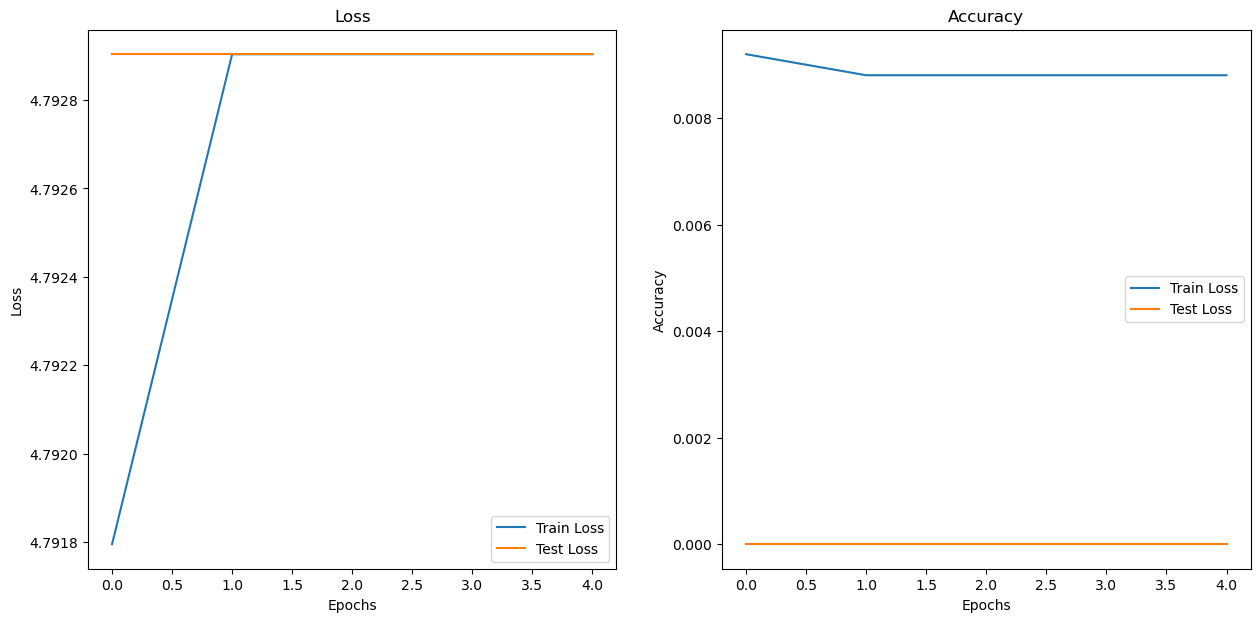

In [17]:
plot_loss_curves(dog_scanner_results)